In [16]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
import re
from wordcloud import WordCloud,STOPWORDS
from sklearn.feature_extraction.text import CountVectorizer 



[nltk_data] Downloading package stopwords to /home/tony/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/tony/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [17]:
df = pd.read_csv('./books-listing-train.csv')
df_test = pd.read_csv('./books-listing-test.csv')


In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10800 entries, 0 to 10799
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Amazon ID (ASIN)  10800 non-null  object
 1   Filename          10800 non-null  object
 2   Image URL         10800 non-null  object
 3   Title             10800 non-null  object
 4   Author            10257 non-null  object
 5   Category ID       10800 non-null  int64 
 6   Category          10800 non-null  object
dtypes: int64(1), object(6)
memory usage: 590.8+ KB


In [19]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1200 entries, 0 to 1199
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Amazon ID (ASIN)  1200 non-null   object
 1   Filename          1200 non-null   object
 2   Image URL         1200 non-null   object
 3   Title             1200 non-null   object
 4   Author            1143 non-null   object
 5   Category ID       1200 non-null   int64 
 6   Category          1200 non-null   object
dtypes: int64(1), object(6)
memory usage: 65.8+ KB


In [20]:
df.drop(['Amazon ID (ASIN)','Filename','Image URL'],axis=1,inplace=True)
df_test.drop(['Amazon ID (ASIN)','Filename','Image URL'],axis=1,inplace=True)

In [21]:
def review_to_words(raw_review): 
    review = raw_review
    review = re.sub('[^a-zA-Z]', ' ',review)
    review = review.lower()
    review = review.split()
    lemmatizer = WordNetLemmatizer()
    review = [lemmatizer.lemmatize(w) for w in review if not w in set(stopwords.words('english'))]
    return (' '.join(review))


In [22]:
corpus= []
for i in range(0, 10800):
    corpus.append(review_to_words(df['Title'][i]))

In [23]:
corpus_test= []
for i in range(0, 1200):
    corpus_test.append(review_to_words(df_test['Title'][i]))

In [24]:
df['new_Title']=corpus

In [25]:
df.head()

,Title,Author,Category ID,Category,new_Title
0,Jonathan Toews (Hockey Superstars),Brenda Haugen,4,Children's Books,jonathan toews hockey superstar
1,Presidential Elections and Other Cool Facts,Syl Sobel J.D.,4,Children's Books,presidential election cool fact
2,How to Draw 101 Animals,NaN,4,Children's Books,draw animal
3,Martin Luther King and the Montgomery Story,Alfred Hassler,4,Children's Books,martin luther king montgomery story
4,"Monster High: Boo York, Boo York: The Junior N...",Mattel,4,Children's Books,monster high boo york boo york junior novel


# Wordcloud show most usage words

In [26]:
words = ' '.join(df['new_Title'])
split_word = " ".join([word for word in words.split()])

In [27]:
wordcloud = WordCloud(stopwords=STOPWORDS,
                      background_color='black',
                      width=3000,
                      height=2500
                     ).generate(split_word)

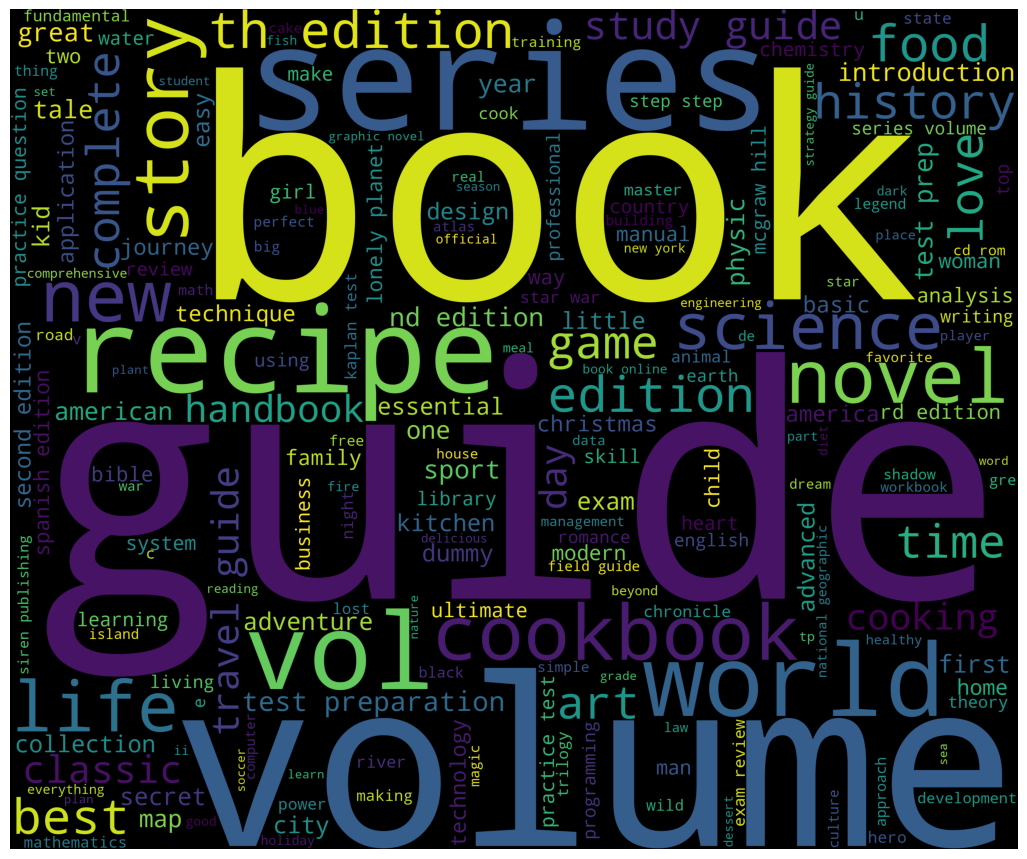

In [28]:
plt.figure(1,figsize=(13, 13))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

# Count every words

In [29]:
vectorizer = CountVectorizer(analyzer = "word",   
                             tokenizer = None,    
                             preprocessor = None, 
                             stop_words = None,   
                             max_features = 2000) 

In [30]:
title_data = df['new_Title']

In [31]:
title_data_words = vectorizer.fit_transform(title_data)

In [32]:
title_data_words = title_data_words.toarray()

In [33]:
title_data= vectorizer.get_feature_names_out()

In [34]:
title_data

array(['abc', 'absolute', 'academic', ..., 'zero', 'zombie', 'zone'],
      dtype=object)

In [35]:
print (title_data_words.shape)


(10800, 2000)


In [36]:
dist = np.sum(title_data_words, axis=0)
for tag, count in zip(title_data, dist):
    print (tag,count) 

abc 8
absolute 7
academic 17
academy 12
accepted 8
access 30
accidental 6
account 8
accounting 27
ace 11
achieve 6
act 65
action 21
active 7
activity 31
actual 9
adaptive 10
administration 16
administrator 9
admission 29
adobe 13
adult 20
advance 14
advanced 85
adventure 124
advice 10
affair 9
africa 21
african 13
age 49
agent 10
agile 9
agriculture 8
aid 14
air 20
al 7
alaska 14
alaskan 8
algebra 32
algeria 7
algorithm 16
alice 11
alien 17
alkaloid 10
along 10
alpine 6
amazing 30
amazon 17
america 92
american 114
amish 18
among 18
amour 9
analogy 17
analysis 67
analytics 22
anatomy 11
ancient 34
andorra 6
android 23
angel 15
angeles 7
animal 60
animation 6
anna 6
anne 6
anniversary 14
answer 29
anthology 14
antigua 7
anyone 7
ap 41
apache 7
apocalypse 10
app 10
appalachian 7
appetizer 6
apple 14
application 97
applied 23
approach 50
apps 13
aptitude 9
arab 7
arabia 9
archery 8
architecture 19
arco 6
area 21
arizona 7
arm 6
armenia 11
army 8
around 25
arrow 7
art 143
arthur 13
artist 1

In [37]:
title_new = pd.DataFrame(dist)

In [38]:
title_new.columns=['word_count']

In [39]:
title_new['word'] = pd.Series(title_data, index=title_new.index)

In [40]:
title_new1=title_new[['word','word_count']]

In [41]:
title_new1.head()

,word,word_count
0,abc,8
1,absolute,7
2,academic,17
3,academy,12
4,accepted,8


In [42]:
top_30_words=title_new1.sort_values(['word_count'],ascending=[0])

In [43]:
top_30_words.head(30)

,word,word_count
806,guide,1232
557,edition,816
196,book,795
1911,volume,562
1782,test,498
1589,series,488
1472,recipe,448
1909,vol,361
615,exam,335
1214,new,288


# Train


In [44]:
cv = CountVectorizer(max_features = 1500)
x__train = cv.fit_transform(corpus).toarray()
x__test = cv.fit_transform(corpus_test).toarray()


In [45]:
target = df['Category'].values
X_train, X_test, y_train, y_test = train_test_split(x__train, target, test_size=0.2, random_state=42)


In [46]:
from sklearn.naive_bayes import MultinomialNB
classifier = MultinomialNB()
classifier.fit(X_train, y_train)

y_pred = classifier.predict(X_test)

y_real_pred = classifier.predict(x__test)


In [50]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
# Accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

# accuracy_real = accuracy_score(y_test, y_real_pred)
# print(f"Accuracy: {accuracy_real}")

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
# print("Confusion Matrix:")
# print(cm)

# Classification Report
report = classification_report(y_test, y_pred)
print("Classification Report:")
print(report)

Accuracy: 0.6675925925925926
Classification Report:
                           precision    recall  f1-score   support

         Children's Books       0.47      0.42      0.44       217
  Comics & Graphic Novels       0.65      0.58      0.61       212
   Computers & Technology       0.80      0.83      0.81       207
   Cookbooks, Food & Wine       0.84      0.87      0.85       233
                  Romance       0.58      0.57      0.57       212
           Science & Math       0.67      0.60      0.63       215
Science Fiction & Fantasy       0.44      0.60      0.51       200
        Sports & Outdoors       0.70      0.58      0.64       227
         Test Preparation       0.84      0.87      0.85       219
                   Travel       0.70      0.73      0.72       218

                 accuracy                           0.67      2160
                macro avg       0.67      0.67      0.66      2160
             weighted avg       0.67      0.67      0.67      2160



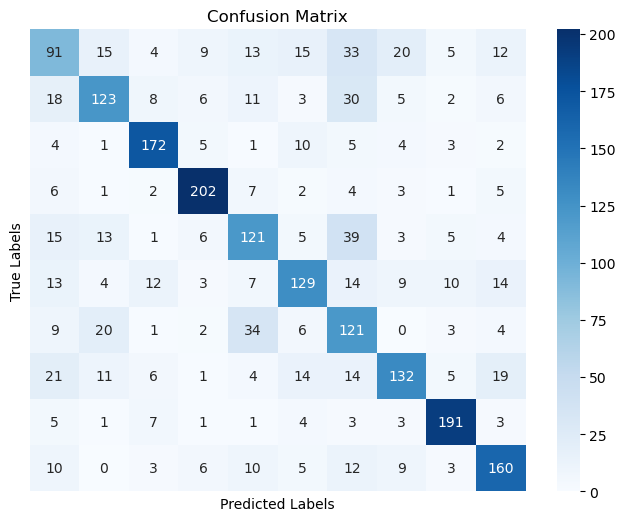

In [48]:
import seaborn as sns

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=[], yticklabels=[])
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()